In [1]:
DATASET_PATH = '../data/raw/data_carrers.csv'
OUTPUT_PATH = '../data/processed/processed-dataset.csv'
import pandas as pd
import numpy as np
import torch
import random
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AdamW, get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,  confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.metrics import classification_report
import seaborn as sns
import spacy
import re

# Cargar el modelo de SpaCy para español
nlp = spacy.load("es_core_news_sm")

# Import libraries
import torch
import warnings
warnings.filterwarnings("ignore")

# 1) Modelo para traducir de español a inglés
model_name_es_en = "Helsinki-NLP/opus-mt-es-en"
translator_es_en = pipeline(
    "translation_es_to_en",
    model=model_name_es_en,
    tokenizer=model_name_es_en
)

# 2) Modelo para traducir de inglés a español
model_name_en_es = "Helsinki-NLP/opus-mt-en-es"
translator_en_es = pipeline(
    "translation_en_to_es",
    model=model_name_en_es,
    tokenizer=model_name_en_es
)


from transformers import PegasusForConditionalGeneration, PegasusTokenizer

model_name = "tuner007/pegasus_paraphrase"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

def paraphrase_pegasus(input_text, num_return_sequences=2):
    batch = tokenizer(
        [input_text],
        truncation=True,
        padding="longest",
        return_tensors="pt"
    )
    outputs = model.generate(
        **batch,
        max_length=521,
        num_beams=5,
        num_return_sequences=num_return_sequences,
        temperature=1.5,
        top_k=50,
        top_p=0.9,
        repetition_penalty=2.5
    )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)




def manual_back_translation(text, translator_es_en, translator_en_es):
    # 1) Traducir de español a inglés
    result_en = translator_es_en(text, max_length=512, truncation=True)
    # result_en es una lista de diccionarios [{'translation_text': "..."}]
    text_en = result_en[0]["translation_text"]

    # 2) Traducir la versión en inglés de vuelta a español
    result_es = translator_en_es(text_en, max_length=512, truncation=True)
    text_es = result_es[0]["translation_text"]

    return text_es


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Device set to use cpu
Device set to use cpu
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:

# # Cargar el dataset
# df = pd.read_csv(DATASET_PATH, encoding="UTF-8")

# df_augmented_texts = []
# df_augmented_labels = []
# for idx, row in df.iterrows():
#     original_text = row['TEXTO']
#     label = row['CARRERA']

#     for _ in range(1):
#         # Ejecutar la traducción ida y vuelta
#         back_translated = manual_back_translation(
#             original_text,
#             translator_es_en,
#             translator_en_es
#         )
#         df_augmented_texts.append(back_translated)
#         df_augmented_labels.append(label)
#     # Genera, por ejemplo, 1 o 2 versiones back-translated
#     # ¡Ojo! Esto puede ser lento si tu dataset es grande
    
#     text = translator_es_en(original_text, max_length=512, truncation=True) 

#     paraphrased_texts = paraphrase_pegasus(text[0]['translation_text'])

#     for para_text in paraphrased_texts:
#         df_augmented_texts.append(translator_en_es(para_text, max_length=512, truncation=True)[0]['translation_text'] )
#         df_augmented_labels.append(label)
        

# # Crear el df de ejemplos aumentados
# df_aug = pd.DataFrame({
#     'TEXTO': df_augmented_texts,
#     'CARRERA': df_augmented_labels
# })

# # Concatenar con el original
# df_final = pd.concat([df, df_aug]).reset_index(drop=True)

# df = df_final


# # Eliminar valores nulos y duplicados
# df = df.dropna()
# df = df.drop_duplicates()
# # Preprocesar el texto
# def preprocess_text(text):
#     text = text.lower()
#     text = re.sub(r'[^\w\sáéíóúñü]', '', text)  # Elimina caracteres especiales pero mantiene caracteres acentuados
#     text = re.sub(r'\s+', ' ', text)  # Reemplaza múltiples espacios por uno solo
#     text = text.strip()  # Elimina espacios en blanco al inicio y al final
    
#         # Procesar el texto con SpaCy para eliminar stopwords y lematizar
#     doc = nlp(text)
#     cleaned_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

#     return cleaned_text


# df['TEXTO'] = df['TEXTO'].apply(preprocess_text)


# df.to_csv(OUTPUT_PATH, index=False)

# num_registros = df.shape[0]
# print(f"Número total de registros en el dataset final: {num_registros}")

# print(labels)


In [3]:
df = pd.read_csv(DATASET_PATH, encoding="UTF-8")

# Mapear las categorías a índices numéricos
categories = df['CARRERA'].unique().tolist()
category_to_index = {category: idx for idx, category in enumerate(categories)}

df = pd.read_csv(OUTPUT_PATH, encoding="UTF-8")


texts = df['TEXTO'].tolist()
labels = df['LABEL'].tolist()

label_counts = df['LABEL'].value_counts()
print(label_counts)

print(categories)


LABEL
0     266
1     266
2     266
3     266
4     266
5     266
6     266
7     266
8     266
9     266
10    266
11    266
12    266
13    266
14    266
15    266
16    266
Name: count, dtype: int64
['INDUSTRIAL', 'CIVIL', 'INFORMÁTICA', 'TELECOMUNICACIONES', 'ARQUITECTURA', 'FILOSOFÍA', 'PSICOLOGÍA', 'LETRAS', 'COMUNICACIÓN SOCIAL', 'EDUCACIÓN', 'ADMINISTRACIÓN', 'CONTADURÍA', 'RELACIONES INDUSTRIALES', 'SOCIOLOGÍA', 'ECONOMÍA', 'DERECHO', 'TEOLOGÍA']


In [4]:


tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
labels = torch.tensor(labels)



In [5]:
## Distribucion del dataset en diferentes conjuntos 


dataset = TensorDataset(input_ids, attention_mask, labels)

# Convertir tensores a numpy arrays
input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()
labels_np = labels.numpy()

# División en entrenamiento+validación y prueba
X_train_val, X_test, y_train_val, y_test, mask_train_val, mask_test = train_test_split(
    input_ids_np, labels_np, attention_mask_np, test_size=0.2, random_state=42, stratify=labels_np)

# División en entrenamiento y validación
X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(
    X_train_val, y_train_val, mask_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(y_train, y_val.shape, y_test.shape)
# Convertir a tensores
train_dataset = TensorDataset(torch.tensor(X_train,dtype=torch.long), torch.tensor(mask_train,dtype=torch.long), torch.tensor(y_train,dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val,dtype=torch.long), torch.tensor(mask_val,dtype=torch.long), torch.tensor(y_val,dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(mask_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long))
# Crear DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)


[ 3 10  5 ...  7 14  6] (905,) (905,)


In [6]:

## Configuracion del modelo bert y carga del modelo preentrenado
config = BertConfig.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', 
                                    num_labels=len(category_to_index), 
                                    hidden_dropout_prob=0.3, 
                                    attention_probs_dropout_prob=0.3)

model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', config=config)

## Definicion del optimizador AdamW
optimizer = AdamW(model.parameters(), lr=1e-5,eps=1e-8, weight_decay=0.01)

## Balanceo de pesos de clases mediante la funcion compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

## Aleatoriedad de generacion de valores para las librerias 
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
## BUCLE DE ENTRENAMIENTO

epochs = 20
total_steps = len(train_dataloader) * epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)
patience = 1
early_stopping_counter = 0
best_val_loss = float('inf')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Después de calcular class_weights
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn = CrossEntropyLoss(weight=class_weights)
model.to(device)
model.train()

training_losses = []
validation_losses = []
validation_accuracies = []
training_accuracies = []
training_f1_scores = []
validation_f1_scores = [] 
learning_rates = []


for epoch in range(epochs):
    ### Entrenamiento ###
    model.train()
    total_train_loss = 0
    train_predictions = []
    train_true_labels = []

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Entrenamiento"):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Almacenar predicciones y etiquetas
        preds = torch.argmax(logits, dim=1)
        train_predictions.extend(preds.cpu().numpy())
        train_true_labels.extend(labels.cpu().numpy())
        
    learning_rates.append(optimizer.param_groups[0]['lr'])

    
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(avg_train_loss)
    
    # Calcular métricas de entrenamiento
    train_accuracy = accuracy_score(train_true_labels, train_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
    train_true_labels, train_predictions, average='weighted')
    training_accuracies.append(train_accuracy)
    training_f1_scores.append(f1)


    ### Validación ###
    model.eval()
    total_val_loss = 0
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for batch in tqdm(validation_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Validación"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_predictions.extend(preds.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = total_val_loss / len(validation_dataloader)
    validation_losses.append(avg_val_loss)

    # Calcular precisión en validación
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    validation_accuracies.append(val_accuracy)
    
    # Después de calcular avg_val_loss y val_accuracy, agrega:
    precision, recall, f1, _ = precision_recall_fscore_support(
        val_true_labels, val_predictions, average='weighted')
    validation_f1_scores.append(f1)
    


    print(f"Epoch {epoch+1}/{epochs}, Pérdida Entrenamiento: {avg_train_loss:.4f}, Pérdida Validación: {avg_val_loss:.4f}, Precisión Validación: {val_accuracy:.4f}")
    
    # Definir variables para Early Stopping
    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model_state.bin')  # Guarda el mejor modelo
    else:
        early_stopping_counter += 1
        print(f"No hay mejora en la pérdida de validación. Paciencia: {early_stopping_counter}/{patience}")

    if early_stopping_counter >= patience:
        print("Early Stopping activado")
        break

Epoch 1/20 - Validación: 100%|██████████| 29/29 [00:14<00:00,  1.99it/s]


Epoch 1/20, Pérdida Entrenamiento: 2.8532, Pérdida Validación: 2.8250, Precisión Validación: 0.0707


Epoch 2/20 - Validación: 100%|██████████| 29/29 [00:14<00:00,  1.97it/s]


Epoch 2/20, Pérdida Entrenamiento: 2.8192, Pérdida Validación: 2.7348, Precisión Validación: 0.2033


Epoch 3/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Epoch 3/20, Pérdida Entrenamiento: 2.6345, Pérdida Validación: 2.0948, Precisión Validación: 0.6331


Epoch 4/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.87it/s]


Epoch 4/20, Pérdida Entrenamiento: 1.8482, Pérdida Validación: 1.0797, Precisión Validación: 0.8044


Epoch 5/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Epoch 5/20, Pérdida Entrenamiento: 1.1420, Pérdida Validación: 0.6966, Precisión Validación: 0.8320


Epoch 6/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Epoch 6/20, Pérdida Entrenamiento: 0.7931, Pérdida Validación: 0.5140, Precisión Validación: 0.8707


Epoch 7/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Epoch 7/20, Pérdida Entrenamiento: 0.6037, Pérdida Validación: 0.4176, Precisión Validación: 0.8829


Epoch 8/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.86it/s]


Epoch 8/20, Pérdida Entrenamiento: 0.4839, Pérdida Validación: 0.3575, Precisión Validación: 0.8939


Epoch 9/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Epoch 9/20, Pérdida Entrenamiento: 0.4115, Pérdida Validación: 0.3265, Precisión Validación: 0.9094


Epoch 10/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Epoch 10/20, Pérdida Entrenamiento: 0.3548, Pérdida Validación: 0.2890, Precisión Validación: 0.9127


Epoch 11/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Epoch 11/20, Pérdida Entrenamiento: 0.3211, Pérdida Validación: 0.2728, Precisión Validación: 0.9193


Epoch 12/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Epoch 12/20, Pérdida Entrenamiento: 0.2942, Pérdida Validación: 0.2586, Precisión Validación: 0.9260


Epoch 13/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Epoch 13/20, Pérdida Entrenamiento: 0.2648, Pérdida Validación: 0.2431, Precisión Validación: 0.9293


Epoch 14/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Epoch 14/20, Pérdida Entrenamiento: 0.2489, Pérdida Validación: 0.2320, Precisión Validación: 0.9315


Epoch 15/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Epoch 15/20, Pérdida Entrenamiento: 0.2403, Pérdida Validación: 0.2254, Precisión Validación: 0.9359


Epoch 16/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Epoch 16/20, Pérdida Entrenamiento: 0.2330, Pérdida Validación: 0.2213, Precisión Validación: 0.9359


Epoch 17/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Epoch 17/20, Pérdida Entrenamiento: 0.2230, Pérdida Validación: 0.2199, Precisión Validación: 0.9370


Epoch 18/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.90it/s]


Epoch 18/20, Pérdida Entrenamiento: 0.2232, Pérdida Validación: 0.2182, Precisión Validación: 0.9381


Epoch 19/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.90it/s]


Epoch 19/20, Pérdida Entrenamiento: 0.2102, Pérdida Validación: 0.2176, Precisión Validación: 0.9370


Epoch 20/20 - Validación: 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Epoch 20/20, Pérdida Entrenamiento: 0.2215, Pérdida Validación: 0.2175, Precisión Validación: 0.9370


In [8]:
##CELDA PARA EL REPORTE DE CLASIFICACION FINAL 

# Cargar el mejor modelo
model.load_state_dict(torch.load('best_model_state.bin', weights_only=True))

model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluación en Conjunto de Prueba"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy()) 

# Generar el reporte de clasificación

print(classification_report(test_true_labels, test_predictions, target_names=categories))


Evaluación en Conjunto de Prueba: 100%|██████████| 29/29 [00:15<00:00,  1.90it/s]

                         precision    recall  f1-score   support

             INDUSTRIAL       0.89      0.91      0.90        53
                  CIVIL       0.90      0.89      0.90        53
            INFORMÁTICA       0.98      0.91      0.94        53
     TELECOMUNICACIONES       0.91      0.98      0.95        54
           ARQUITECTURA       0.91      0.92      0.92        53
              FILOSOFÍA       0.98      1.00      0.99        53
             PSICOLOGÍA       1.00      0.93      0.96        54
                 LETRAS       0.98      1.00      0.99        53
    COMUNICACIÓN SOCIAL       0.96      0.94      0.95        53
              EDUCACIÓN       0.96      0.98      0.97        53
         ADMINISTRACIÓN       0.85      0.83      0.84        54
             CONTADURÍA       0.92      0.92      0.92        53
RELACIONES INDUSTRIALES       0.95      0.96      0.95        54
             SOCIOLOGÍA       0.98      1.00      0.99        53
               ECONOMÍA 

<Figure size 1800x500 with 0 Axes>

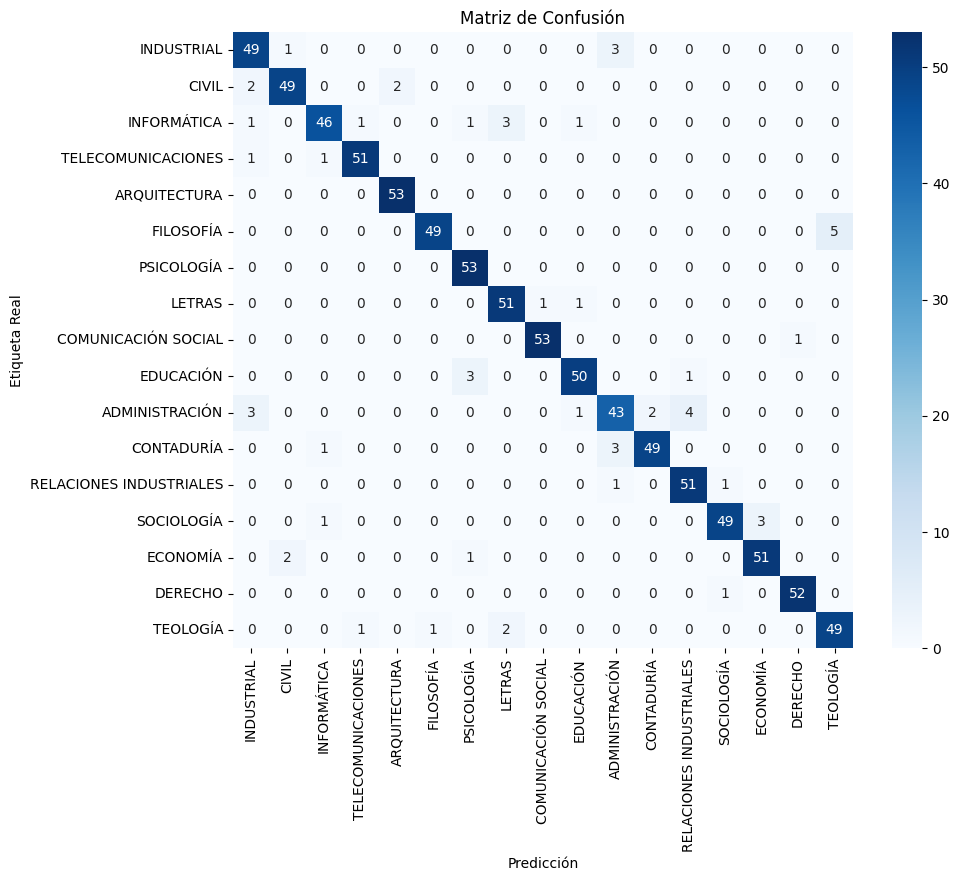

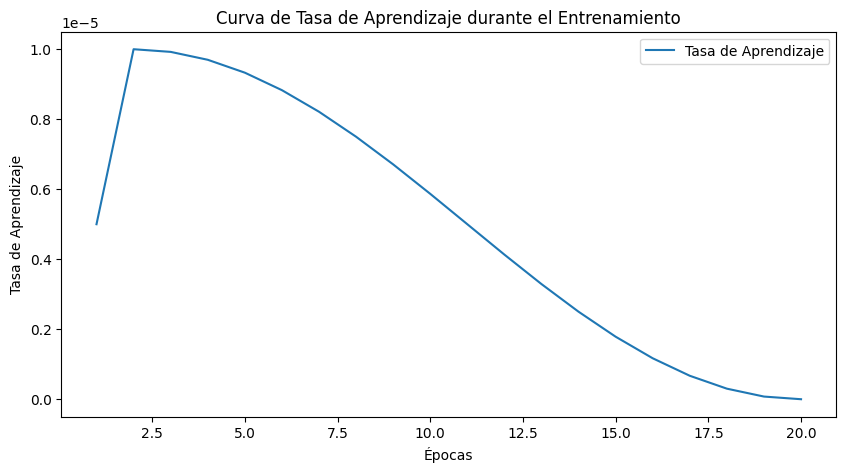

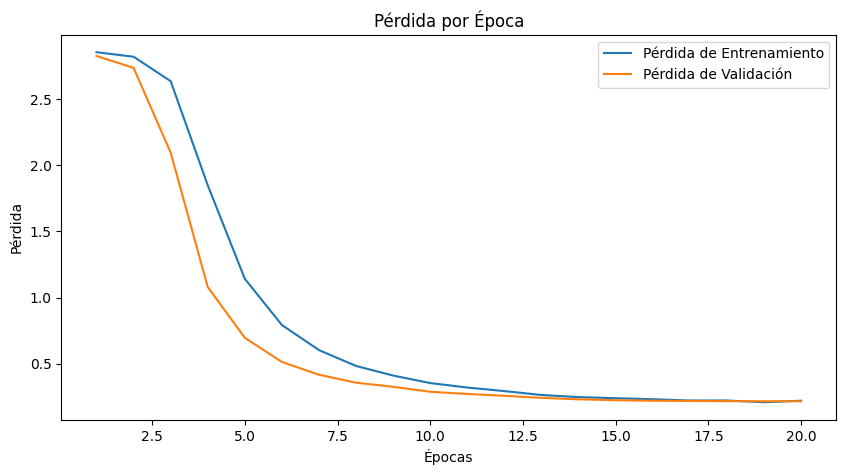

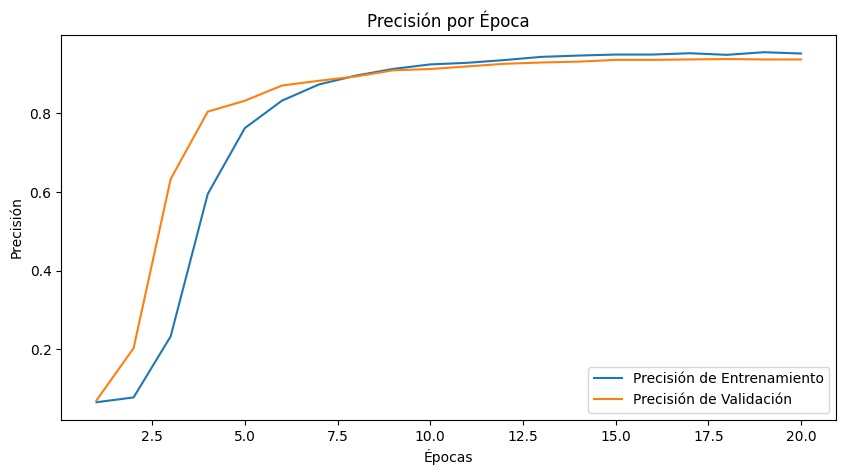

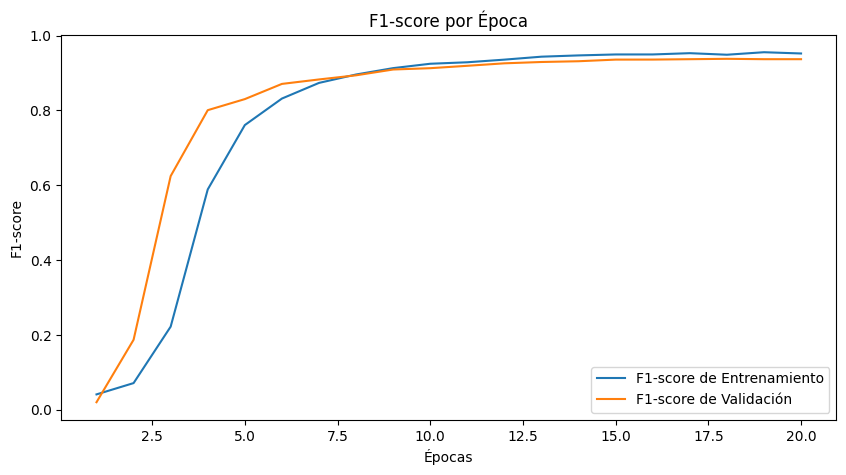

In [9]:

  
## MONITOREO DE GRÁFICOS Y METRICAS

epochs_range = range(1, len(training_losses) + 1)

plt.figure(figsize=(18, 5))

# Obtener la matriz de confusión en el conjunto de validación
conf_matrix = confusion_matrix(val_true_labels, val_predictions)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

# Gráfica de tasa de aprendizaje
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(learning_rates) + 1), learning_rates, label="Tasa de Aprendizaje")
plt.xlabel('Épocas')
plt.ylabel('Tasa de Aprendizaje')
plt.title('Curva de Tasa de Aprendizaje durante el Entrenamiento')
plt.legend()
plt.show()

# Gráfica de pérdidas
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, training_losses, label='Pérdida de Entrenamiento')
plt.plot(epochs_range, validation_losses, label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida por Época')
plt.show()

# Gráfica de precisión
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, training_accuracies, label='Precisión de Entrenamiento')
plt.plot(epochs_range, validation_accuracies, label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión por Época')
plt.show()

# Gráfica de F1-score
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, training_f1_scores, label='F1-score de Entrenamiento')
plt.plot(epochs_range, validation_f1_scores, label='F1-score de Validación')
plt.xlabel('Épocas')
plt.ylabel('F1-score')
plt.legend()
plt.title('F1-score por Época')
plt.show()
